#### Import wymaganych bibliotek

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
from pandas.tseries import offsets

import osmnx as ox
import geopandas as gpd
import maxrect
import cvxpy
from descartes import PolygonPatch
from shapely.geometry import Polygon, MultiPolygon, LineString
from shapely.ops import unary_union

from timezonefinder import TimezoneFinder
from datetime import date

from pvlib import solarposition
from pvlib import location
from pvlib import irradiance
from pvlib import iotools

import warnings
warnings.filterwarnings("ignore")

#### Sekcja ustawień

###### Dane geograficzne

In [2]:
west, south, east, north = 18.96429,52.9297,18.986743,52.933942

###### Parametry systemu

Parametry modułu PV

In [3]:
# Model modułu słonecznego - Sunpower SPR-230-WHT-U
# http://www.solardesigntool.com/components/module-panel-solar/Sunpower/SPR-230-WHT-U/specification-data-sheet.html

z = 0.798 #szerokość modułu [m]
L = 1.559 #długość modułu [m]

P_n = 230.01 # moc znamionowa w warunkach STC [Wp]
Um_mpp = 41 # napięcie znamionowe w MPP [V]
Im_mpp = 5.61 # natężenie znamionowe w MPP [A]
Um_oc = 48.7 # napięcie obwodu otwartego [V]

T_NOCT = 45 #temperatura modułu w warunkach NOCT [C_deg]
T_coeff_Pmax = -0.38 # procentowy współczynnik temperaturowy mocy w MPP [%/C_deg]

Parametry inwertera

In [4]:
#Model inwertera - KACO Blueplanet 2200 TL3
# https://www.enfsolar.com/pv/inverter-datasheet/9447

Ui_dc = 800 # maksymalne napięcie po stronie DC [V]
Ui_mpp_max = 800 # górny zakres napięcia DC w MPP [V]
Ui_mpp_min = 580 # dolny zakres napięcia DC w MPP [V]
Ii_dc = 3234.1998 # maksymalne natężenie po stronie DC [A]

P_i_max = 2200000 # maksymalna moc dopuszczalna na inwerterze [W]
P_i_nom = 2000000 # moc nominalna inwertera [W]
n_i_conv = 0.988  # sprawność inwertera [-]
P_i_k = 2000 # konsumpcja energii na potrzeby własne [W]

###### Sprawność pozostałych elementów systemu i straty w systemie

In [5]:
d = 0.069
Ac = 0.015

n_i_mppt = 0.99
n_k_dc = 0.985
n_n = 0.02

n_t = 0.99
n_k_ac = 0.995

EAF = 0.995
timestep = 1 #[h]

#### Wyznaczenie dostępnego terenu 

In [6]:
def download_footprints(west, south, east, north,footprints_type = 'landuse'):
    polygon = ox.utils_geo.bbox_to_poly(north,south,east,west)
    footprints_gdf = ox.footprints_from_polygon(polygon,footprint_type=footprints_type)
    
    return polygon, footprints_gdf


def filter_footprints(footprints_gdf, footprints_type = 'landuse', chosenFootprints = ['farmland','forest','grass','meadow']):
    filtered_gdf = footprints_gdf.loc[footprints_gdf[footprints_type].isin(chosenFootprints)]
    
    return filtered_gdf

def modified_get_maximal_rectangle(coordinates):
    
    """
    Find the largest, inscribed, axis-aligned rectangle.
    :param coordinates:
        A list of of [x, y] pairs describing a closed, convex polygon.
    """

    coordinates = np.array(coordinates)
    x_range = np.max(coordinates, axis=0)[0]-np.min(coordinates, axis=0)[0]
    y_range = np.max(coordinates, axis=0)[1]-np.min(coordinates, axis=0)[1]

    scale = np.array([x_range, y_range])
    sc_coordinates = coordinates/scale

    poly = Polygon(sc_coordinates)
    inside_pt = (poly.representative_point().x,
                 poly.representative_point().y)

    A1, A2, B = maxrect.pts_to_leq(sc_coordinates)

    bl = cvxpy.Variable(2)
    tr = cvxpy.Variable(2)
    br = cvxpy.Variable(2)
    tl = cvxpy.Variable(2)
    obj = cvxpy.Maximize(cvxpy.log(tr[0] - bl[0]) + cvxpy.log(tr[1] - bl[1]))
    constraints = [bl[0] == tl[0],
                   br[0] == tr[0],
                   tl[1] == tr[1],
                   bl[1] == br[1],
                   ]

    for i in range(len(B)):
        if inside_pt[0] * A1[i] + inside_pt[1] * A2[i] <= B[i]:
            constraints.append(bl[0] * A1[i] + bl[1] * A2[i] <= B[i])
            constraints.append(tr[0] * A1[i] + tr[1] * A2[i] <= B[i])
            constraints.append(br[0] * A1[i] + br[1] * A2[i] <= B[i])
            constraints.append(tl[0] * A1[i] + tl[1] * A2[i] <= B[i])

        else:
            constraints.append(bl[0] * A1[i] + bl[1] * A2[i] >= B[i])
            constraints.append(tr[0] * A1[i] + tr[1] * A2[i] >= B[i])
            constraints.append(br[0] * A1[i] + br[1] * A2[i] >= B[i])
            constraints.append(tl[0] * A1[i] + tl[1] * A2[i] >= B[i])

    prob = cvxpy.Problem(obj, constraints)
        
    try:
        solver='ECOS'
        prob.solve(solver=solver, verbose=False)
    except:
        try:
            solver='ECOS_BB'
            prob.solve(solver=solver, verbose=False)
        except:
            try:
                solver='CVXOPT'
                prob.solve(solver=solver, verbose=False)
            except:
                try:
                    solver='OSQP'
                    prob.solve(solver=solver, verbose=False)
                except:
                    try:
                        solver='GLPK'
                        prob.solve(solver=solver, verbose=False)   
                    except:
                        try:
                            solver='GLPK_MI'
                            prob.solve(solver=solver, verbose=False)  
                        except:
                            solver='SCS'
                            prob.solve(solver=solver, verbose=False)  
    
    print('Used solver: {0}'.format(solver))
    bottom_left = np.array(bl.value).T * scale
    top_right = np.array(tr.value).T * scale

    return list(bottom_left), list(top_right)

def fit_plot_ranctangle_polygon(polygon):
    coordinates = list(polygon.exterior.coords)
    ll, ur = maxrect.get_maximal_rectangle(coordinates)
    calculated_coordinates = maxrect.rect2poly(ll,ur)
    
    poly_coordinates = Polygon(coordinates)
    poly_calculated = Polygon(calculated_coordinates)
    
    x,y = poly_coordinates.exterior.xy
    a,b = poly_calculated.exterior.xy
    
    plt.plot(x,y,color="red")
    plt.plot(a,b,color="blue")
    plt.plot()
    
    return poly_calculated

In [7]:
lon = (west + east)/2
lat = (south+north)/2

print("Szerokość geograficzna: {0}\nDługość geograficzna: {1}".format(lat,lon))

Szerokość geograficzna: 52.931821
Długość geograficzna: 18.975516499999998


###### Stworzenie wielokąta z wejściowego "bounding box'a", pobranie footprintów dla danego obszaru

In [8]:
poly, footprints_landuse_gdf = download_footprints(west,south,east,north)
filtered_footprints_landuse_gdf = filter_footprints(footprints_landuse_gdf)

In [9]:
print("Używany system współrzędnych:\n{0}".format(filtered_footprints_landuse_gdf.crs))

Używany system współrzędnych:
epsg:4326


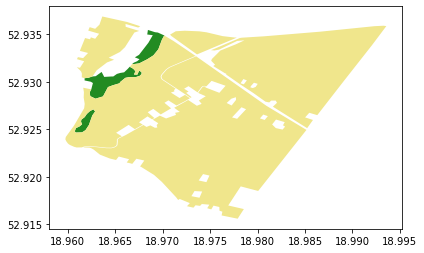

In [10]:
forest_footprints = filtered_footprints_landuse_gdf[filtered_footprints_landuse_gdf['landuse']=='forest']
farmland_footprints = filtered_footprints_landuse_gdf[filtered_footprints_landuse_gdf['landuse']=='farmland']
meadow_footprints = filtered_footprints_landuse_gdf[filtered_footprints_landuse_gdf['landuse']=='meadow']
grass_footprints = filtered_footprints_landuse_gdf[filtered_footprints_landuse_gdf['landuse']=='grass']

fig, ax = plt.subplots(figsize=(6,4))

# Lasy
forest_footprints.plot(ax=ax, facecolor='forestgreen')

# Pola uprawne
farmland_footprints.plot(ax=ax, facecolor="khaki")

# Łąki
meadow_footprints.plot(ax=ax, facecolor="darkseagreen")

# Tereny trawiaste
grass_footprints.plot(ax=ax, facecolor='greenyellow')

plt.tight_layout()

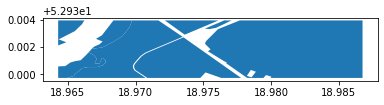

In [11]:
landuse_bbox = filtered_footprints_landuse_gdf['geometry'].intersection(poly)
landuse_bbox_gdf = gpd.GeoDataFrame(geometry=landuse_bbox)
landuse_bbox_gdf = landuse_bbox_gdf[landuse_bbox_gdf.is_empty == False]
landuse_bbox_gdf.plot()

In [12]:
def plot_poly(poly):
    BLUE = '#6699cc'
    fig = plt.figure() 
    ax = fig.gca() 
    ax.add_patch(PolygonPatch(poly, fc=BLUE, ec=BLUE, alpha=0.5, zorder=2 ))
    ax.axis('scaled')
    plt.show()

In [13]:
area_polygon = landuse_bbox_gdf.unary_union

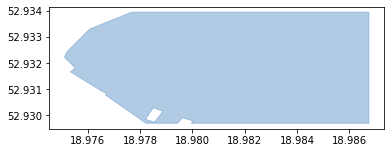

In [14]:
if isinstance(area_polygon, MultiPolygon):
    biggest_poly = 0
    multipoly = area_polygon
    for poly in list(multipoly):
        if(poly.area > biggest_poly):
            new_area_polygon = poly
            biggest_poly = poly.area
    area_polygon = new_area_polygon
    
plot_poly(area_polygon)

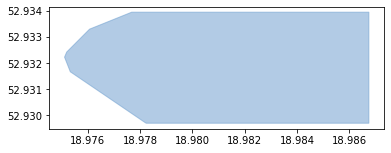

In [15]:
area_convexhull_polygon = area_polygon.convex_hull
plot_poly(area_convexhull_polygon)

In [16]:
area_polygon_utm, crs_utm = ox.projection.project_geometry(area_polygon)
area_convexhull_polygon_utm, crs_utm = ox.projection.project_geometry(area_convexhull_polygon)

print("Wykorzystywana projekcja UTM:\n{0}".format(crs_utm))

Wykorzystywana projekcja UTM:
+proj=utm +zone=34 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs


In [17]:
#monkey patch function
maxrect.get_maximal_rectangle = modified_get_maximal_rectangle

###### Porównanie wyznaczonego obszaru poprzez algorytm w przypadku braku uproszczenia obszaru oraz z zastosowaną wcześniej operacją Convex Hull 

Used solver: ECOS


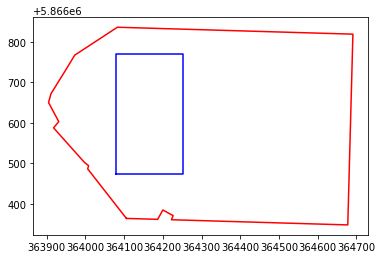

In [18]:
poly_calculated = fit_plot_ranctangle_polygon(area_polygon_utm)

Used solver: ECOS


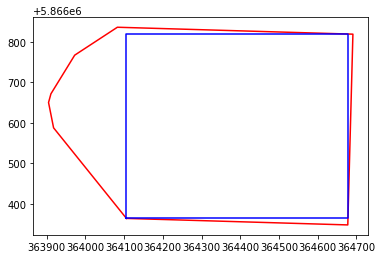

In [19]:
convexhull_poly_calculated = fit_plot_ranctangle_polygon(area_convexhull_polygon_utm)

In [20]:
print("Finalny obszar dostępnego terenu: {0} [m2]".format(round(convexhull_poly_calculated.area,2)))

Finalny obszar dostępnego terenu: 261002.01 [m2]


In [21]:
x_coord_list = []
y_coord_list = []

for x,y in convexhull_poly_calculated.exterior.coords:
    x_coord_list.append(x)
    y_coord_list.append(y)
    
# szerokość terenu
x = math.ceil(max(x_coord_list) - min(x_coord_list)) 

# długość terenu
y = math.ceil(max(y_coord_list) - min(y_coord_list)) 

#### Modelowanie i symulacja pracy instalacji

In [22]:
tf = TimezoneFinder()
tz = tf.timezone_at(lng=lon, lat=lat)

currentYear = date.today().year
yearStart= date.today() - offsets.YearBegin()
yearEnd = yearStart.replace(year = yearStart.year + 1)

times = pd.date_range(yearStart,yearEnd, closed='left',freq='H', tz=tz)

print('Strefa czasowa: ' + tz)
print('Obliczenia dla przedziału czasowego: {0} - {1}'.format(yearStart,yearEnd))

Strefa czasowa: Europe/Warsaw
Obliczenia dla przedziału czasowego: 2020-01-01 00:00:00 - 2021-01-01 00:00:00


In [23]:
data, months_selected, inputs, meta = iotools.get_pvgis_tmy(lat,lon)

altitude = inputs['location']['elevation']

weather_data = data
weather_data['time[UTC]'] = weather_data.index
weather_data = weather_data.assign(time_temp = weather_data['time[UTC]'].apply(lambda x: x.replace(year=currentYear)))
weather_data['time_local'] = weather_data['time_temp'].dt.tz_convert(tz)
weather_data.index = weather_data['time_local']
weather_data.drop(['time[UTC]','time_temp','time_local'], axis=1, inplace=True)

times_df = pd.DataFrame(index=times)
weather = times_df.join(weather_data, how='left')
weather.fillna(0,inplace=True)

weather = weather[['G(h)','Gb(n)','Gd(h)','T2m','WS10m','SP']]
weather.columns = ['ghi', 'dni', 'dhi', 'temp_air', 'wind_speed','pressure']

weather.head()

,ghi,dni,dhi,temp_air,wind_speed,pressure
2020-01-01 00:00:00+01:00,0.0,0.0,0.0,0.00,0.00,0.0
2020-01-01 01:00:00+01:00,0.0,0.0,0.0,-2.65,5.09,98721.0
2020-01-01 02:00:00+01:00,0.0,0.0,0.0,-2.87,5.36,98655.0
2020-01-01 03:00:00+01:00,0.0,0.0,0.0,-3.10,5.63,98589.0
2020-01-01 04:00:00+01:00,0.0,0.0,0.0,-3.32,5.90,98563.0


In [24]:
print("Wysokość n.p.m.: {0} [m]".format(altitude))

Wysokość n.p.m.: 91.0 [m]


In [25]:
solpos = solarposition.get_solarposition(times,lat,lon,altitude,pressure=weather['pressure'],temperature=weather['temp_air'])
solpos.head()

,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time
2020-01-01 00:00:00+01:00,150.031507,150.031507,-60.031507,-60.031507,5.918322,-3.061851
2020-01-01 01:00:00+01:00,147.075300,147.075300,-57.075300,-57.075300,31.925991,-3.081724
2020-01-01 02:00:00+01:00,140.949505,140.949505,-50.949505,-50.949505,53.099200,-3.101587
2020-01-01 03:00:00+01:00,133.014862,133.014862,-43.014862,-43.014862,69.723473,-3.121441
2020-01-01 04:00:00+01:00,124.235861,124.235861,-34.235861,-34.235861,83.389825,-3.141287


###### Wyznaczenie kąta padania promieni słonecznych w południe słoneczne podczas przesilenia zimowego

In [26]:
solpos_elevation = solpos[['elevation']]
solpos_elevation = solpos_elevation.assign(date = pd.to_datetime(solpos_elevation.index.date))
solar_noons = solpos_elevation.groupby(['date'])['elevation'].max().reset_index()
solar_noons

,date,elevation
0,2020-01-01,13.993367
1,2020-01-02,14.080874
2,2020-01-03,14.175829
3,2020-01-04,14.278187
4,2020-01-05,14.387900
...,...,...
361,2020-12-27,13.705098
362,2020-12-28,13.760638
363,2020-12-29,13.823756
364,2020-12-30,13.894420


Wysokość słońca w południe słoneczne podczas przesilenia letniego (słońce najwyżej w ciągu roku)

In [27]:
solar_noon_max = solar_noons[solar_noons['elevation'] == max(solar_noons['elevation'])]
solar_noon_max

,date,elevation
172,2020-06-21,60.38262


Wysokość słońca w południe słoneczne podczas przesilenia zimowego (słońce najniżej w ciągu roku)

In [28]:
solar_noon_min = solar_noons[solar_noons['elevation'] == min(solar_noons['elevation'])]
solar_noon_min

,date,elevation
354,2020-12-20,13.530463


#### Wyznaczenie minimalnego odstępu między rzędami paneli

In [29]:
b = round(abs(lat)) #kąt pochylenia modułów słonecznych [deg]

In [30]:
a = float(solar_noon_min['elevation']) #kąt padania promieni słonecznych w południe słoneczne podczas przesilenia zimowego [deg]

D = (L*np.sin(np.deg2rad(180-a-b)))/np.sin(np.deg2rad(a))
Lx = L * np.cos(np.deg2rad(b))
Ly= L * np.sin(np.deg2rad(b))
Dr = round(D - Lx,2)

print("Długość cienia rzucanego przez rząd modułów PV w południe słoneczne podczas przesilenia zimowego: " + str(Dr) + " [m]")

Długość cienia rzucanego przez rząd modułów PV w południe słoneczne podczas przesilenia zimowego: 5.17 [m]


In [31]:
#obszar na szerokość
x_a = x - 10
n_x = int(x_a / z)

#obszar na długość
y_a = y - 10
n_y = int((y_a + Dr)/ D)

n_max = n_x * n_y

print("Maksymalna ilość modułów PV w rzędach: " + str(n_x))
print("Maksymalna ilość rzędów: " + str(n_y))
print("Maksymalna ilość modułów PV: " + str(n_max))

Maksymalna ilość modułów PV w rzędach: 705
Maksymalna ilość rzędów: 73
Maksymalna ilość modułów PV: 51465


In [32]:
Ui_avg = (Ui_mpp_min + Ui_mpp_max)/2
n_s = math.floor(Ui_avg/Um_mpp)

print("n_s przed korektą: " + str(n_s))
print("n_s * Um_oc równe {0}, Ui_dc równe {1}".format(n_s*Um_oc,Ui_dc))

while(n_s*Um_oc > Ui_dc):
    n_s = n_s - 1
    print("n_s zredukowane o 1, bieżąca wartość n_s równa {0}".format(n_s))
    
print("\nn_s po uwzględnieniu warunku na maksymalną moc na wejściu do inwertera równe: {0}".format(n_s))  

n_s przed korektą: 16
n_s * Um_oc równe 779.2, Ui_dc równe 800

n_s po uwzględnieniu warunku na maksymalną moc na wejściu do inwertera równe: 16


In [33]:
n_r = math.floor(Ii_dc/Im_mpp)
n_i = math.ceil(n_max/(n_s*n_r))

print("n_r równe: {0}".format(n_r))
print("Ilość inwerterów przed korektą: {0}".format(n_i))

while(n_s*n_r*n_i>n_max):
    n_i = n_i-1
    print("Ilość falowników zmniejszona o 1, obecna wartość: {0}".format(n_i))
    
n_pv = n_s*n_r*n_i

print("\nFinalna ilość inwerterów: {0}\nFinalna ilość modułów PV: {1}".format(n_i,n_pv))

n_r równe: 576
Ilość inwerterów przed korektą: 6
Ilość falowników zmniejszona o 1, obecna wartość: 5

Finalna ilość inwerterów: 5
Finalna ilość modułów PV: 46080


In [34]:
P_c_init = n_max * P_n
P_c = n_pv * P_n

print("Wstępna moc zainstalowana (przy maksymalnej ilości modułów PV jaką można zmieścić na wyznaczonym obszarze): {0} [MW]".format(round(P_c_init/1000000,2)))
print("Moc zainstalowana po przeliczeniu: {0} [MW]".format(round(P_c/1000000,2)))

Wstępna moc zainstalowana (przy maksymalnej ilości modułów PV jaką można zmieścić na wyznaczonym obszarze): 11.84 [MW]
Moc zainstalowana po przeliczeniu: 10.6 [MW]


#### Napromieniowanie na powierzchnię pochyłą

In [35]:
site = location.Location(lat,lon,tz,altitude)
azimuth = 180 if lat>=0 else 0
tilt = b

tilt

53

In [36]:
site

Location: 
  name: None
  latitude: 52.931821
  longitude: 18.975516499999998
  altitude: 91.0
  tz: Europe/Warsaw

In [37]:
irradiance_tbl = irradiance.get_total_irradiance(
        surface_tilt=tilt,
        surface_azimuth=azimuth,
        dni=weather['dni'],
        ghi=weather['ghi'],
        dhi=weather['dhi'],
        solar_zenith=solpos['apparent_zenith'],
        solar_azimuth=solpos['azimuth'])

In [38]:
#Przygotowanie tabeli wynikowej
calc_tbl = irradiance_tbl.join(weather, how='left')
calc_tbl.fillna(0,inplace=True)
calc_tbl = calc_tbl[['poa_global','temp_air']]
calc_tbl.columns = ['POA','temp_air']

#Temperatura modułu PV
calc_tbl = calc_tbl.assign(temp_module = calc_tbl['temp_air'] + (calc_tbl['POA']/800)*(T_NOCT-20) )

#Moc MPP modułu PV
calc_tbl = calc_tbl.assign(MPP_P = P_n * (calc_tbl['POA']/1000)*(1-(T_coeff_Pmax/100)*(calc_tbl['temp_module']-25)))

#Rzeczywista moc wyjściowa na module PV
calc_tbl = calc_tbl.assign(P = (1-d)*(1-Ac)*calc_tbl['MPP_P'])

#Straty względem mocy MPP
calc_tbl = calc_tbl.assign(P_loss = calc_tbl['MPP_P']-calc_tbl['P'])

#Moc wejściowa na falowniku (wyjściowa z zestawu modułów PV podłączonych do jednego falownika)
calc_tbl = calc_tbl.assign(P_in = n_s*n_r*n_i_mppt*n_k_dc*(1-n_n)*calc_tbl['P'])

#Moc wyjściowa na falowniku
def calc_power_output(x):
    if x <= P_i_k:
        return 0
    elif x > P_i_max:
        return P_i_max * n_i_conv
    else:
        return x * n_i_conv

calc_tbl = calc_tbl.assign(P_o = calc_tbl['P_in'].apply(calc_power_output))

#Moc jaką elektrownia może przekazać do sieci
calc_tbl = calc_tbl.assign(P_plant = (n_t * n_k_ac * calc_tbl['P_o'] * n_i))

#Energia jaką elektrownia może przekazać do sieci
calc_tbl = calc_tbl.assign(E_plant = (EAF * calc_tbl['P_plant'] * timestep))

calc_tbl

,POA,temp_air,temp_module,MPP_P,P,P_loss,P_in,P_o,P_plant,E_plant
2020-01-01 00:00:00+01:00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 01:00:00+01:00,0.0,-2.65,-2.65,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 02:00:00+01:00,0.0,-2.87,-2.87,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 03:00:00+01:00,0.0,-3.10,-3.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 04:00:00+01:00,0.0,-3.32,-3.32,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2020-12-31 19:00:00+01:00,0.0,-1.30,-1.30,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-31 20:00:00+01:00,0.0,-1.53,-1.53,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-31 21:00:00+01:00,0.0,-1.75,-1.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-31 22:00:00+01:00,0.0,-1.98,-1.98,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
calc_tbl_monthly = calc_tbl.assign(Year_Month = calc_tbl.index.to_period('M'))
calc_tbl_monthly = calc_tbl_monthly.groupby(['Year_Month'])['POA','E_plant'].sum().reset_index()
calc_tbl_monthly = calc_tbl_monthly.assign(POA_kWh_m2 = round(calc_tbl_monthly['POA']/1000,2))
calc_tbl_monthly = calc_tbl_monthly.assign(E_plant_MWh = round(calc_tbl_monthly['E_plant']/1000000,2))
calc_tbl_monthly.drop(columns=['POA','E_plant'], axis=1, inplace=True)

calc_tbl_monthly

,Year_Month,POA_kWh_m2,E_plant_MWh
0,2020-01,43.60,359.50
1,2020-02,52.11,451.60
2,2020-03,100.82,885.55
3,2020-04,139.01,1286.77
4,2020-05,141.95,1323.56
5,2020-06,140.70,1323.42
6,2020-07,151.09,1450.73
7,2020-08,187.33,1832.19
8,2020-09,106.19,992.20
9,2020-10,90.00,828.33


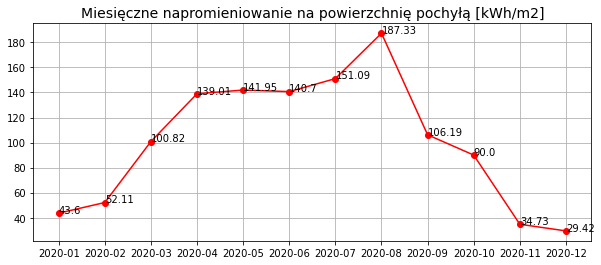

In [40]:
time = calc_tbl_monthly.Year_Month.astype(str).tolist()
POA_val = calc_tbl_monthly.POA_kWh_m2.tolist()
  
fig, ax = plt.subplots(1, 1, figsize = (10, 4))

plt.plot(time, POA_val, color='red', marker='o')
plt.title('Miesięczne napromieniowanie na powierzchnię pochyłą [kWh/m2]', fontsize=14)
plt.grid(True)

for i,j in calc_tbl_monthly.POA_kWh_m2.items():
    ax.annotate(str(j), xy=(i, j))

plt.show()

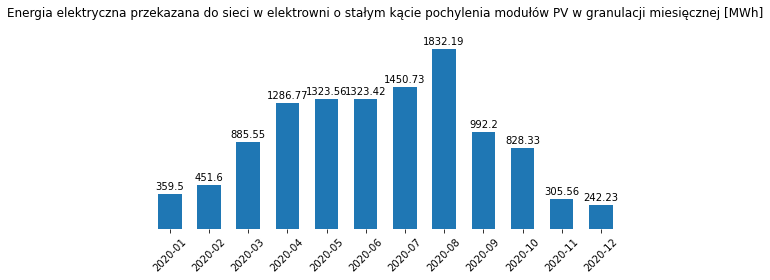

In [41]:
labels = calc_tbl_monthly['Year_Month']
values = calc_tbl_monthly['E_plant_MWh']

x = np.arange(len(labels))
width = 0.6

fig, ax = plt.subplots(1, 1, figsize = (10, 4))

rects1 = ax.bar(x, values, width)

ax.set_title('Energia elektryczna przekazana do sieci w elektrowni o stałym kącie pochylenia modułów PV w granulacji miesięcznej [MWh]')
ax.set_xticks(x)
ax.set_xticklabels(labels,rotation=45)
plt.yticks([])

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
fig.tight_layout()
plt.margins(y=0.15)

for spine in plt.gca().spines.values():
    spine.set_visible(False)
        
plt.show()

In [42]:
E_plant_yr = round(sum(calc_tbl['E_plant'])/1000000,2)
POA_yr = round(sum(calc_tbl['POA'])/1000,2)

print("Energia przekazana do sieci w ciagu roku wynosi: {0} [MWh]\nRoczne napromieniowanie na powierzchnię pochyłą wynosi: {1} [kWh/m2]".format(E_plant_yr,POA_yr))

Energia przekazana do sieci w ciagu roku wynosi: 11281.64 [MWh]
Roczne napromieniowanie na powierzchnię pochyłą wynosi: 1216.95 [kWh/m2]


#### Parametry ewaluacyjne modelu

In [43]:
Annual_energy_kWh = calc_tbl['E_plant'].sum() / 1000
Annual_irradiance_kWh_m2_yr = calc_tbl['POA'].sum() / 1000
Pnom_kWp = P_c / 1000

##### Final Yield

In [44]:
Yf = Annual_energy_kWh/Pnom_kWp
print("Współczynnik wydajności energetycznej (Yf) wynosi: {0} h".format(round(Yf,2)))

Współczynnik wydajności energetycznej (Yf) wynosi: 1064.42 h


##### Performance ratio

In [45]:
PR = Annual_energy_kWh/(Annual_irradiance_kWh_m2_yr*Pnom_kWp)
print("Współczynnik efektywności (PR) dla rozważanego przypadku wynosi: {0} %".format(round(PR*100,2)))

Współczynnik efektywności (PR) dla rozważanego przypadku wynosi: 87.47 %


##### Capacity utilization factor

In [46]:
CUF = Annual_energy_kWh / (Pnom_kWp * 8760)
print("Współczynnik wykorzystania zdolności produkcyjnych (CUF) dla rozważanego przypadku wynosi: {0} %".format(round(CUF*100,2)))

Współczynnik wykorzystania zdolności produkcyjnych (CUF) dla rozważanego przypadku wynosi: 12.15 %


#### Analiza ekonomiczna modelu

In [47]:
P_n_kWp = P_n/1000
P_i_kWp = P_i_nom/1000
P_c_kWp = P_c/1000
E_plant_kWh = E_plant_yr * 1000

In [48]:
C_m = 300 #Koszt modułów PV [EUR/kWp]
C_i = 30 #Koszt inwerterów [EUR/kWp]
C_t = 20 #Koszt step-up transformer [EUR/kWp]
C_b = 120 #Koszty związane z wynagrodzeniem pracowników budowlanych [EUR/kWp]
C_p = 60 #Okablowanie elektryczne, miernik, zabezpieczenia, skrzynki przyłączeniowe, szafy, rozdzielnice, łączniki, bezpieczniki, wyłącznik i inne elementy nieelektryczne [EUR/kWp]

t = 25 #Długość eksploatacji elektrowni PV [lata]
C_u = 15 #Koszty utrzymania elektrowni PV [EUR/kWp/year]
Z_e = 0.055 #Cena energii przy odsprzedaży do sieci [EUR/kWh]

##### Koszty inwestycyjne

In [49]:
Ki_m = C_m * n_pv * P_n_kWp
Ki_i = C_i * n_i * P_i_kWp
Ki_t = C_t * P_c_kWp
Ki_b = C_b * P_c_kWp
Ki_p = C_p * P_c_kWp
Ki = Ki_m + Ki_i + Ki_t + Ki_b + Ki_p
Ki = round(Ki,2)

##### Koszty utrzymania instalacji w okresie t eksploatacji

In [50]:
Ku = P_c_kWp * C_u * t
Ku = round(Ku,2)

##### Koszty związane z wymianą elementów systemu PV

In [51]:
n_w = int(t/15) #Ilość wymian inwerterów

Kw = Ki_i * n_w
Kw = round(Kw,2) #Koszty związane z wymianą elementów systemu PV

#### Podsumowanie i rozkład kosztów

In [52]:
print("""
Koszty inwestycyjne: {0} EUR
Koszty związane z utrzymaniem instalacji w całym okresie eksploatacji: {1} EUR [w ciągu {3} lat]
Koszty związane z wymianą elementów systemu PV: {2} EUR
""".format(Ki, Ku, Kw,t))


Koszty inwestycyjne: 5599430.4 EUR
Koszty związane z utrzymaniem instalacji w całym okresie eksploatacji: 3974572.8 EUR [w ciągu 25 lat]
Koszty związane z wymianą elementów systemu PV: 300000.0 EUR



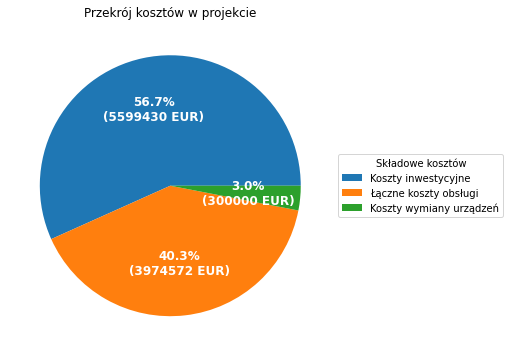

In [53]:
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(aspect="equal"))
data = [Ki, Ku, Kw]
desc = ['Koszty inwestycyjne','Łączne koszty obsługi','Koszty wymiany urządzeń']

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d} EUR)".format(pct, absolute)

wedges, texts, autotexts = ax.pie(data,autopct=lambda pct: func(pct, data),textprops=dict(color="w"))

ax.legend(wedges, desc,
          title="Składowe kosztów",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=12, weight="bold")
ax.set_title("Przekrój kosztów w projekcie")
plt.show()

##### Rozkład kosztów inwestycyjnych

In [54]:
d1 = [Ki_m, Ki_i, Ki_t, Ki_b, Ki_p]
d2 = list(map(lambda x: round((x/Ki)*100,3),d1))
idx = ['Moduły PV','Inwertery','Transformator','Montaż','Pozostałe']
capital_df = pd.DataFrame(index=idx,data= {'Koszt [EUR]':d1, 'Procent całości [%]':d2})
capital_df.loc["Total"] = capital_df.sum()

capital_df.style.format("{:.2f}")

,Koszt [EUR],Procent całości [%]
Moduły PV,3179658.24,56.78
Inwertery,300000.00,5.36
Transformator,211977.22,3.79
Montaż,1271863.30,22.71
Pozostałe,635931.65,11.36
Total,5599430.40,100.00


##### Przepływ pieniężny rok do roku

In [55]:
cashflow_df = pd.DataFrame(index=range(0,t+1))
cashflow_df = cashflow_df.assign(Wpływy = Z_e * E_plant_kWh)
cashflow_df = cashflow_df.assign(Utrzymanie = -(P_c_kWp* C_u))
cashflow_df = cashflow_df.assign(Wydatki_jednorazowe = 0)
cashflow_df.iloc[0] = 0
cashflow_df.iloc[0,2] = -Ki #koszty inwestycyjne
cashflow_df.iloc[15,2] = cashflow_df.iloc[15,2] - Kw #koszty wymiany elementów systemu
cashflow_df = cashflow_df.assign(Cash_flow = cashflow_df.sum(axis=1))

cashflow_df.style.format("{:.2f}")

,Wpływy,Utrzymanie,Wydatki_jednorazowe,Cash_flow
0,0.00,0.00,-5599430.40,-5599430.40
1,620490.20,-158982.91,0.00,461507.29
2,620490.20,-158982.91,0.00,461507.29
3,620490.20,-158982.91,0.00,461507.29
4,620490.20,-158982.91,0.00,461507.29
5,620490.20,-158982.91,0.00,461507.29
6,620490.20,-158982.91,0.00,461507.29
7,620490.20,-158982.91,0.00,461507.29
8,620490.20,-158982.91,0.00,461507.29
9,620490.20,-158982.91,0.00,461507.29


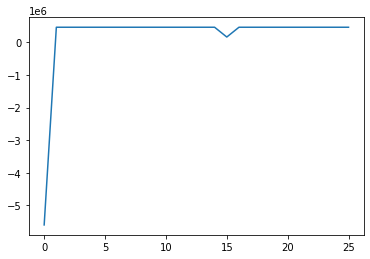

In [56]:
plt.plot(list(cashflow_df.index), list(cashflow_df.Cash_flow))

In [57]:
cashflows = list(cashflow_df.Cash_flow)
discount_rate = 0.05

npv = round(np.npv(discount_rate,cashflows),2)

print("""
Wskaźnik NPV wynosi: {0} EUR
""".format(npv))


Wskaźnik NPV wynosi: 760722.6 EUR

